In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go
import gmsh
import meshio

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import KNeighborsClassifier

In [25]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [26]:
qo = 1e-3   # W/mm^2
# Cp = 658 #J/kg.K
# rho = 7.6e-6 #kg/mm^3
# kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 2 #mm/s
Q = 5 #W/mm2

In [27]:
# def rho(T):
#     if T < 100000:                # alpha
#         return (-5.13*10**(-5)*(T**2) - 0.01935*T + 4451)*(10**(-9))
#     elif T < 1878:              #beta
#         return (-2.762**10**(-6)*(T**2) - 0.1663*T + 4468)*(10**(-9))
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
#     else:                       # liquidous
#         return (-0.565*T+5093)*(10**(-9))

# def Cp(T):
#     if T < 100000:                # alpha
#         return 0.25*T+483
#     elif T < 1878:              #beta
#         return 0.14*T+530
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
#     else:                       # liquidous
#         return 930
    
# def Kappa(T):
#     if T < 100000:                # alpha
#         return (0.012*T+3.3)/1000
#     elif T < 1878:              #beta
#         return (0.016*T-3)/1000
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
#     else:                       # liquidous
#         return (0.0175*T-4.5)/1000 

In [28]:
def rho(phase,T):
    if phase == 'alpha':                # alpha
        return (-5.13e-5*(T**2)-0.01935*T+4451)*(1e-9)
    elif phase == 'beta':              #beta
        return (-2.762e-6*(T**2)-0.1663*T+4468)*(1e-9)
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
    elif phase == 'liquidous':                       # liquidous
        return (-0.565*T+5093)*(10**(-9))

def Cp(phase,T):
    if phase == 'alpha':                # alpha
        return 0.25*T+483
    elif phase == 'beta':              #beta
        return 0.14*T+530
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
    elif phase == 'liquidous':                       # liquidous
        return 930
    
def Kappa(phase,T):
    if phase == 'alpha':                # alpha
        return (0.012*T+3.3)/1000
    elif phase == 'beta':              #beta
        return (0.016*T-3)/1000
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
    elif phase == 'liquidous':                       # liquidous
        return (0.0175*T-4.5)/1000 
    
def whichPhase(T):
    if T < 1268:                # alpha
        return 'alpha'
    elif T < 1928:              #beta
        return 'beta'
    else:                       # liquidous
        return 'liquidous'

In [29]:
def Gaussian(X,sigma,mu):
    return Q*math.exp(-((X-mu) @ (X-mu).T) / (sigma**2))
def NeumannBoundaryCondition(x,y):
    return qo

In [30]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,valuesPrevIteration,valuesPrevStep) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*valuesPrevStep).T
        self.TemperatureForPhaseProperties =  (np.ones((1,len(self.coords)))*valuesPrevIteration).T
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
        gmsh.model.mesh.field.add("Constant", 1)  # Add a constant field with ID 1
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Set mesh size factor for Plane 3 to 1
        gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID)
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular1.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open('rectangle_2.msh')
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([50,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            phaseOfElement = whichPhase(T = np.mean(self.TemperatureForPhaseProperties[triNodesTags[ele]-1]))
            rho_cp_element = 1
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                k_element = Kappa(phaseOfElement,T=(N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho(phaseOfElement,T=(N@Temperature)[0][0]) * Cp(phaseOfElement,T=(N@Temperature)[0][0])     # density * heat capacity         
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp_element
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                if det_jac < 0:
                    print('fv')
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            dN = np.array([-0.5,0.5]).T
            coordinates = coords[linearNodes[ele]-1].T 
            det_Jac = np.linalg.norm(coordinates@dN)
            if det_Jac < 0:
                print('vfdv')
            for pt in range(gaussPoints):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                # print(x)
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [31]:
# Taking phase change into consideration
#################
### Workhorse ###
#################
class RectangularMeshInvolvingPhaseChange:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,valuesPrevIteration,valuesPrevStep,xDisplacementOfSource) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*valuesPrevStep).T
        self.TemperatureForPhaseProperties =  (np.ones((1,len(self.coords)))*valuesPrevIteration).T
        self.mu = np.array([xDisplacementOfSource,25])
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
        gmsh.model.mesh.field.add("Constant", 1)  # Add a constant field with ID 1
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Set mesh size factor for Plane 3 to 1
        gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID)
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular1.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open('rectangle_vary_0.5_1.msh')
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        TemperatureForPhaseProperties = self.TemperatureForPhaseProperties.copy()
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = self.mu
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            N = np.array([1/3, 1/3, 1/3]).reshape(1,-1)
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            phaseOfElement = whichPhase(T = np.mean(TemperatureForPhaseProperties[triNodesTags[ele]-1]))
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                k_element = Kappa(phase=phaseOfElement,T=(N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho(phase=phaseOfElement,T=(N@Temperature)[0][0]) * Cp(phase=phaseOfElement,T=(N@Temperature)[0][0])     # density * heat capacity         
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

## Picard iteration for moving source heat conduction

In [32]:
def PicardIteration(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=dirichiletBoundaryTemperature,valuesPrevIteration=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    T_prev_iter = mesh.Temperature
    T_prev_iter[np.where(mesh.coords[:,0] >= 45)] = T_prev_iter[np.where(mesh.coords[:,0] >= 45)] +1000
    TT = T_prev_iter.copy()
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<10):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=T_old.T,valuesPrevIteration=T_prev_iter.T)
        A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
        T_new = np.ones((n,1))*dirichiletBoundaryTemperature
        F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
        T_new[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
        if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
            break
        T_old = T_new
        if np.array_equal(T_prev_iter,TT):
            print('grg')
    return T_prev_iter,T_new,mesh
    # return mesh

In [33]:
# tt,t,mesh = PicardIteration(5,1)

In [34]:
# np.max(t)

In [35]:
# plt.figure(figsize=(8,4))
# plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],t.reshape(-1),cmap='jet')
# plt.colorbar()
# plt.show()

In [36]:
def PicardIterationRevised(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=dirichiletBoundaryTemperature,valuesPrevIteration=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    T_prev_iter = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)
    
    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=T_old.T,valuesPrevIteration=T_prev_iter.T)
        A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
        T_new = np.ones((n,1))*dirichiletBoundaryTemperature
        F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
        T_new[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
        if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
            break
        T_old = T_new
    return T_new,mesh
    # return mesh

In [37]:
def PicardIterationSparse(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(
        meshFactorForEntireSurface=meshFactorForEntireSurface,
        meshFactorForPatchSurface=meshFactorForPatchSurface,
        geo_file='rectange.geo',
        values=dirichiletBoundaryTemperature
    )
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=T_old.T)
        A_sparse = csr_matrix(mesh.A)
        K_sparse = csr_matrix(mesh.K)
        S_sparse = csr_matrix(mesh.S)
        Boundary_sparse = csr_matrix(mesh.Boundary)
        T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

        # Compute the combined sparse matrix F
        F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

        # Compute the right-hand side for the sparse system
        rhs = (
            S_sparse + Boundary_sparse
            - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
            (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
        )
        rhs_interior = rhs[interiorNodes]

        # Solve for T_new at interior nodes using the sparse solver
        T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
        T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
        if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
            break
        T_old = T_new_dense
    return T_new_dense,mesh
    # return mesh

In [38]:
def PicardIterationSparseForMovingSource(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    L = 100
    T = int(abs(L/vo))
    steps = 10
    delta_t = T/steps
    tol = 4*1e-5
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMeshInvolvingPhaseChange(
                meshFactorForEntireSurface=meshFactorForEntireSurface,
                meshFactorForPatchSurface=meshFactorForPatchSurface,
                valuesPrevStep=dirichiletBoundaryTemperature,
                valuesPrevIteration=dirichiletBoundaryTemperature,
                geo_file='rectange.geo',
                xDisplacementOfSource = 0
            )    
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    Temperatures = np.ones((steps+1,n))*dirichiletBoundaryTemperature
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)
    print(mesh.coords.shape)
    print(mesh.triNodesTags.shape)
    ##Workhorse of Picard 
    for timestep in range(1,steps+1):
        it = 0
        T_old = Temperatures[timestep-1,:].reshape(-1,1) + 1200
        while(it<40):       ##Preventing infinite loop
            it += 1
            mesh = RectangularMeshInvolvingPhaseChange(
                meshFactorForEntireSurface=meshFactorForEntireSurface,
                meshFactorForPatchSurface=meshFactorForPatchSurface,
                valuesPrevStep=T_old.T,
                valuesPrevIteration=Temperatures[timestep-1,:].reshape(1,-1),
                geo_file='rectange.geo',
                xDisplacementOfSource = timestep*vo
            )
            A_sparse = csr_matrix(mesh.A)
            K_sparse = csr_matrix(mesh.K)
            S_sparse = csr_matrix(mesh.S)
            Boundary_sparse = csr_matrix(mesh.Boundary)
            T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

            # Compute the combined sparse matrix F
            F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

            # Compute the right-hand side for the sparse system
            rhs = (
                S_sparse + Boundary_sparse
                - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
                (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
            )
            rhs_interior = rhs[interiorNodes]

            # Solve for T_new at interior nodes using the sparse solver
            T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
            T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
            print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
            if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
                break
            T_old = T_new_dense
        print('Time Step '+str(timestep))
        print('Sum of K ele '+str(np.sum(mesh.A)))
        print('Sum of G ele '+str(np.sum(mesh.K)))
        print('Sum of F ele '+str(np.sum(mesh.S)))
        print('Sum of Bc ele '+str(np.sum(mesh.Boundary)))
        scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=T_new_dense, cmap='jet', s=1, edgecolor=None)
        plt.legend()
        plt.colorbar(scatter, label='Value')
        plt.show()
        Temperatures[timestep,:] = T_new_dense.reshape(-1)
        print(np.max(Temperatures[timestep,:]))
    return Temperatures,mesh
    # return mesh

(9806, 2)
(19286, 3)
Error after iteration 1 is 109811.13334393247
Error after iteration 2 is 13087.183295887604
Error after iteration 3 is 2388.07851020855
Error after iteration 4 is 196.45616899764443
Error after iteration 5 is 25.531544176657423
Error after iteration 6 is 4.24724520411958
Error after iteration 7 is 0.4356243414805548
Error after iteration 8 is 0.04808872928065728
Error after iteration 9 is 0.010059573491939658
Error after iteration 10 is 0.0011243652630539664
Error after iteration 11 is 0.00010960062757288376
Error after iteration 12 is 2.3875198863053e-05
Time Step 1
Sum of K ele 1.8370721610594387e-15
Sum of G ele -2.7755575615628914e-17
Sum of F ele 57.890117549221664
Sum of Bc ele 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


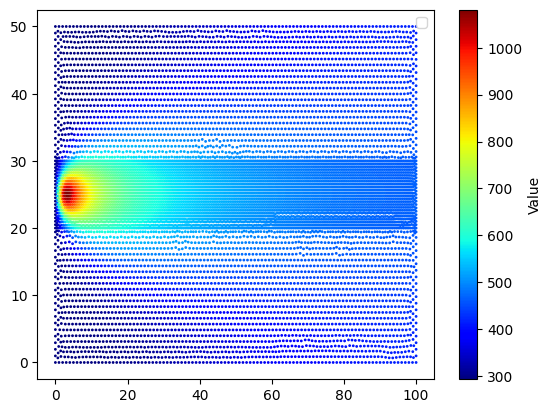

1081.189999251429
Error after iteration 1 is 124333.78851206704
Error after iteration 2 is 17177.67869115385
Error after iteration 3 is 2800.2238812661185
Error after iteration 4 is 324.7499089767223
Error after iteration 5 is 63.21105461563313
Error after iteration 6 is 5.217376883998778
Error after iteration 7 is 1.450420205338838
Error after iteration 8 is 0.15716760295920412
Error after iteration 9 is 0.02955506903147658
Error after iteration 10 is 0.005154690285544801
Error after iteration 11 is 0.0005443307166374658
Error after iteration 12 is 0.0001462144422369178
Error after iteration 13 is 1.2156051858791043e-05
Time Step 2
Sum of K ele 6.305719835175694e-16
Sum of G ele 2.168404344971009e-18
Sum of F ele 62.68488437125759
Sum of Bc ele 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


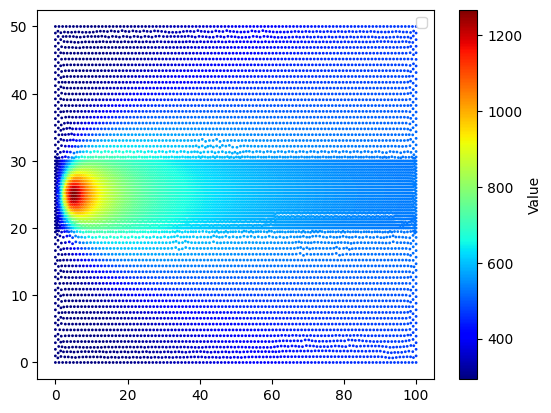

1267.0356052830941
Error after iteration 1 is 129043.54153048032
Error after iteration 2 is 16949.305106246753
Error after iteration 3 is 2342.098355190738
Error after iteration 4 is 384.0081352351181
Error after iteration 5 is 50.283780754536544
Error after iteration 6 is 7.249004111006337
Error after iteration 7 is 1.2282211655765318
Error after iteration 8 is 0.15390889358469834
Error after iteration 9 is 0.030781621177880598
Error after iteration 10 is 0.0034615535632983663
Error after iteration 11 is 0.0007799334619279178
Error after iteration 12 is 7.973775698672057e-05
Error after iteration 13 is 1.975004044838833e-05
Time Step 3
Sum of K ele 1.222980050563649e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sum of G ele -1.5937771935536915e-17
Sum of F ele 62.831136320332675
Sum of Bc ele 0.5


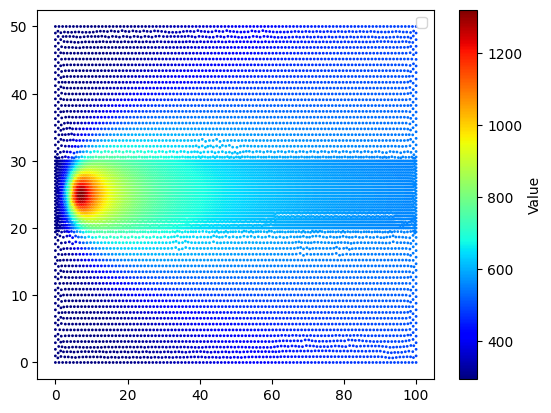

1319.9615431472569
Error after iteration 1 is 129989.75994473363
Error after iteration 2 is 15933.632864720397
Error after iteration 3 is 1951.4652923559433
Error after iteration 4 is 430.18126085158605
Error after iteration 5 is 43.431929969532035
Error after iteration 6 is 10.049088644695532
Error after iteration 7 is 1.0701220895683086
Error after iteration 8 is 0.2596642783963544
Error after iteration 9 is 0.027284005785996133
Error after iteration 10 is 0.007033365099156526
Error after iteration 11 is 0.0007126647437916798
Error after iteration 12 is 0.00019397723576433312
Error after iteration 13 is 1.885704558652268e-05
Time Step 4
Sum of K ele 1.2828280104848488e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sum of G ele 1.0869126779167182e-17
Sum of F ele 62.83182986316201
Sum of Bc ele 0.5


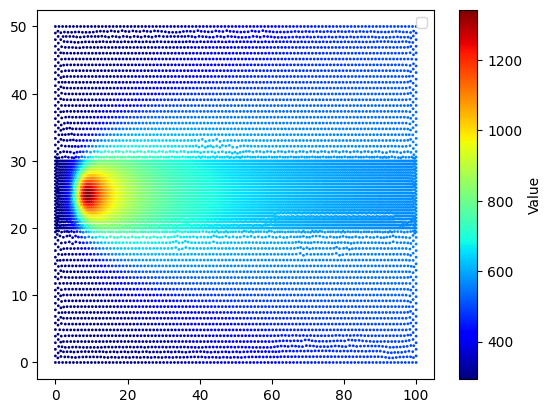

1343.1584201346627
Error after iteration 1 is 129968.31488215267
Error after iteration 2 is 15171.225650043383
Error after iteration 3 is 1776.9320234690706
Error after iteration 4 is 425.29023096504744
Error after iteration 5 is 39.464022727709676
Error after iteration 6 is 10.420305220186254
Error after iteration 7 is 0.9731642133638695
Error after iteration 8 is 0.28156510267261176
Error after iteration 9 is 0.02542738443819748
Error after iteration 10 is 0.007929413704299233
Error after iteration 11 is 0.000700248355513291
Error after iteration 12 is 0.00022587549750316283
Error after iteration 13 is 2.015172718672834e-05
Time Step 5
Sum of K ele 6.817463260588852e-16


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sum of G ele -8.538092108323347e-18
Sum of F ele 62.83182882473319
Sum of Bc ele 0.5


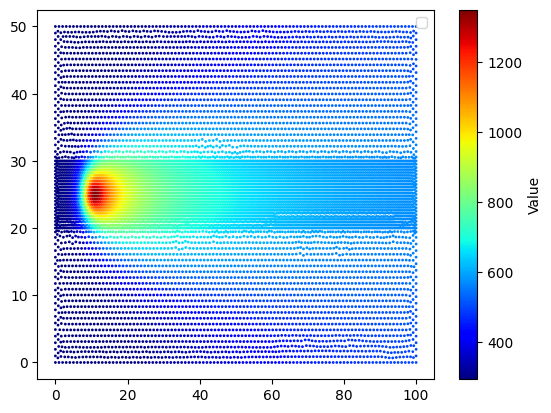

1349.5237027158191
Error after iteration 1 is 129633.7741641028
Error after iteration 2 is 14714.330060231232
Error after iteration 3 is 1692.5927545563204
Error after iteration 4 is 417.7169684597933
Error after iteration 5 is 37.71260561022341
Error after iteration 6 is 10.410073258811337
Error after iteration 7 is 0.9394977214173789
Error after iteration 8 is 0.2854724507518267
Error after iteration 9 is 0.02524443732237972
Error after iteration 10 is 0.0081346603347166
Error after iteration 11 is 0.0007276400146836817
Error after iteration 12 is 0.0002336934772499608
Error after iteration 13 is 2.2142590348284833e-05
Time Step 6
Sum of K ele 2.157996004115148e-15
Sum of G ele -7.887570804832045e-17
Sum of F ele 62.83182789044888
Sum of Bc ele 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


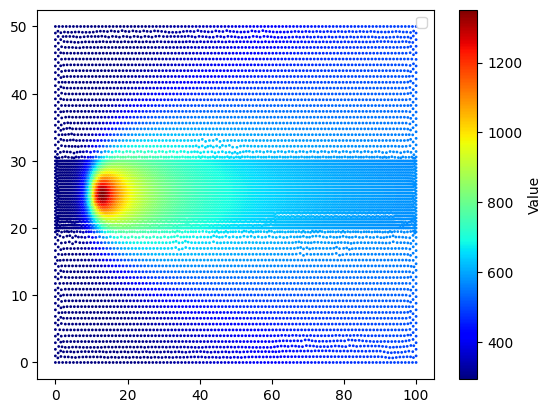

1351.4196820464042
Error after iteration 1 is 129320.56090617007
Error after iteration 2 is 14452.003536621527
Error after iteration 3 is 1650.4582194180987
Error after iteration 4 is 412.4533994166773
Error after iteration 5 is 36.88733262516281
Error after iteration 6 is 10.37080259928913
Error after iteration 7 is 0.9259615592127102
Error after iteration 8 is 0.2869892227767356
Error after iteration 9 is 0.025348518580998222
Error after iteration 10 is 0.008242309536117955
Error after iteration 11 is 0.0007515922479537792
Error after iteration 12 is 0.00023818044771605317
Error after iteration 13 is 2.3601947522904206e-05
Time Step 7
Sum of K ele 2.422541334201611e-15
Sum of G ele -2.5695591487906455e-17
Sum of F ele 62.83182776225959
Sum of Bc ele 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


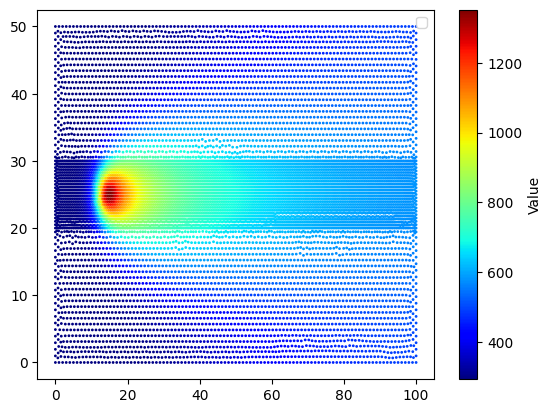

1352.2187555104347
Error after iteration 1 is 129072.5736475665
Error after iteration 2 is 14294.554268539887
Error after iteration 3 is 1629.3381729943733
Error after iteration 4 is 407.45376602068814
Error after iteration 5 is 36.4274489954597
Error after iteration 6 is 10.25288389670892
Error after iteration 7 is 0.9148083052127318
Error after iteration 8 is 0.2837775878289346
Error after iteration 9 is 0.025048486992093378
Error after iteration 10 is 0.008148508925898032
Error after iteration 11 is 0.0007427625437933636
Error after iteration 12 is 0.00023538170598208638
Error after iteration 13 is 2.33250111151611e-05
Time Step 8
Sum of K ele 1.3209919269563386e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sum of G ele -1.1058862159352145e-17
Sum of F ele 62.831827916512296
Sum of Bc ele 0.5


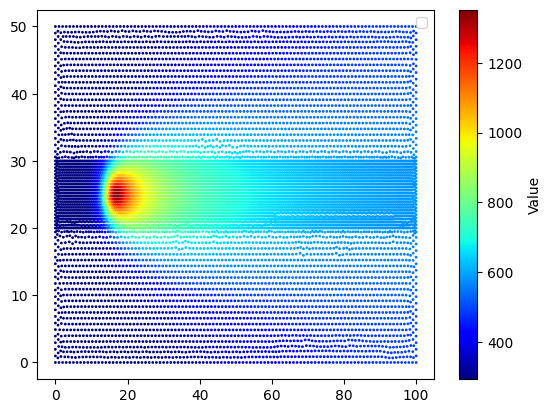

1352.2667877381375
Error after iteration 1 is 128856.71737572324
Error after iteration 2 is 14186.88224129212
Error after iteration 3 is 1617.5227672841518
Error after iteration 4 is 403.50759974486016
Error after iteration 5 is 36.147037454399936
Error after iteration 6 is 10.158044930802498
Error after iteration 7 is 0.9074577767304152
Error after iteration 8 is 0.28129506500859225
Error after iteration 9 is 0.024821940070822206
Error after iteration 10 is 0.008080111022443383
Error after iteration 11 is 0.0007351435514861163
Error after iteration 12 is 0.00023346837813466442
Error after iteration 13 is 2.3065096253986244e-05
Time Step 9
Sum of K ele 1.3114509478384662e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sum of G ele -2.9652929417478546e-17
Sum of F ele 62.83182845230299
Sum of Bc ele 0.5


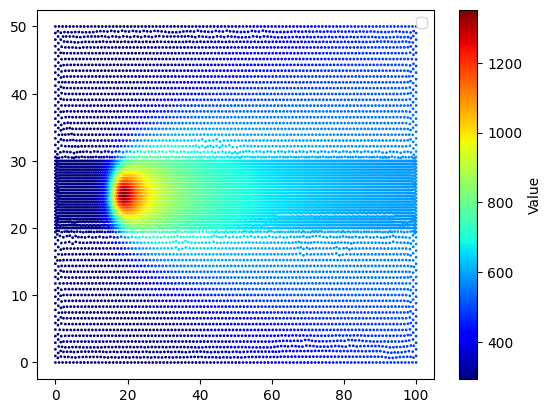

1352.2915743299395
Error after iteration 1 is 128663.56633174334
Error after iteration 2 is 14102.702647705142
Error after iteration 3 is 1610.1635639772699
Error after iteration 4 is 399.99778567484276
Error after iteration 5 is 35.94642036131017
Error after iteration 6 is 10.07174833261053
Error after iteration 7 is 0.901697769088383
Error after iteration 8 is 0.27907000629440093
Error after iteration 9 is 0.02462361854409236
Error after iteration 10 is 0.008020519188079599
Error after iteration 11 is 0.0007278948042747899
Error after iteration 12 is 0.00023185886803577684
Error after iteration 13 is 2.2805971315027036e-05
Time Step 10
Sum of K ele 2.048708425128609e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sum of G ele -3.903127820947816e-18
Sum of F ele 62.83182835350819
Sum of Bc ele 0.5


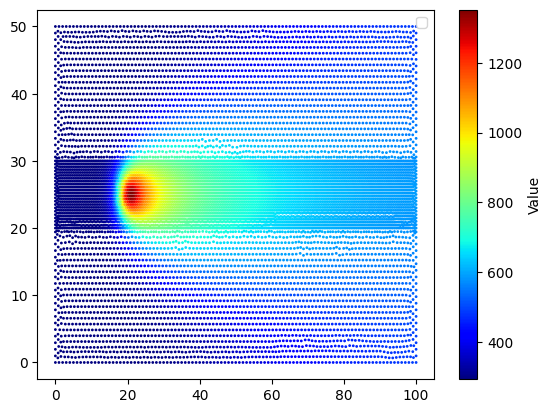

1352.3103784631894


In [39]:
# T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 3,meshFactorForPatchSurface=0.07)
# T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 1.5,meshFactorForPatchSurface=0.5)
T,mesh = PicardIterationSparseForMovingSource(meshFactorForEntireSurface = 3,meshFactorForPatchSurface=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1352.3103784631894


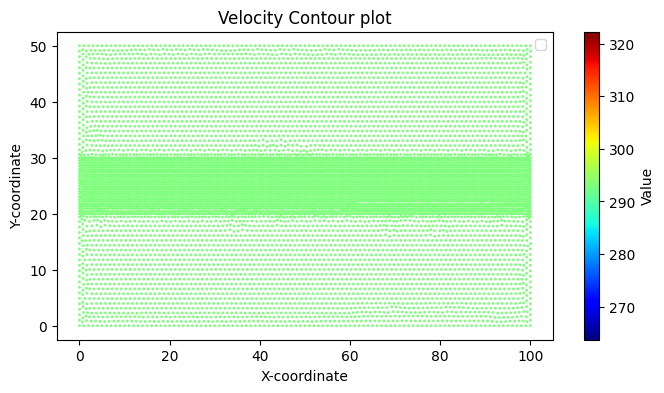

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


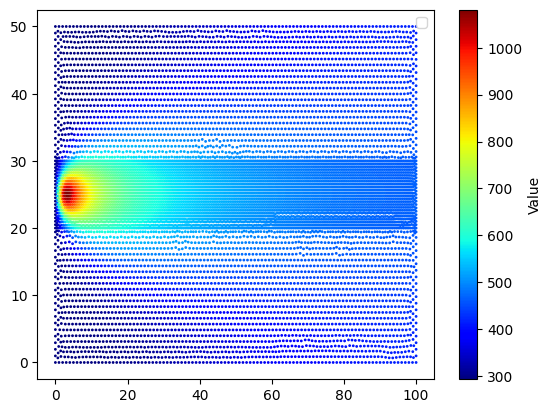

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


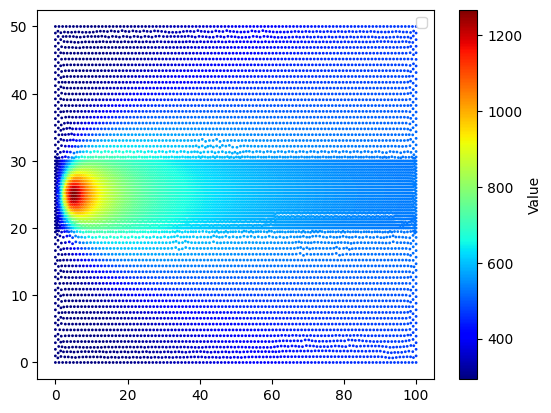

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


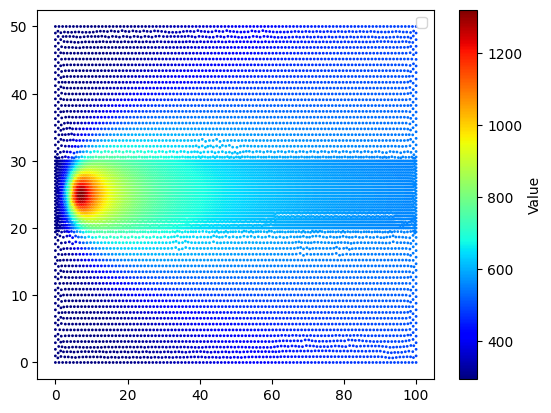

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


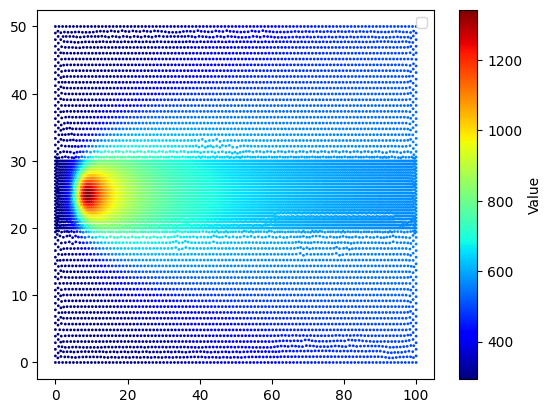

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


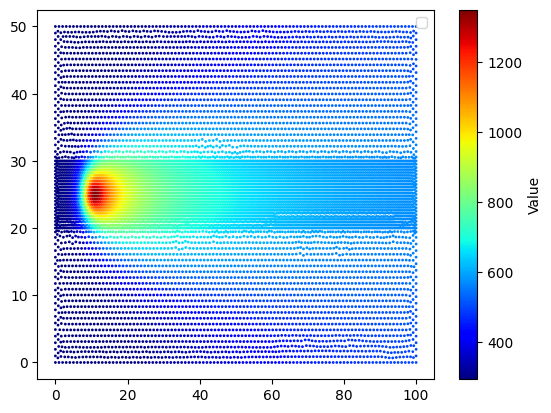

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


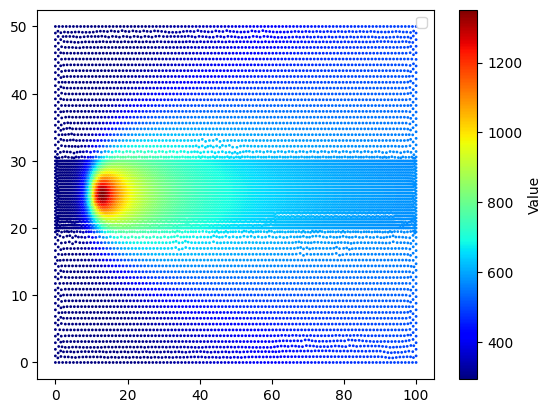

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


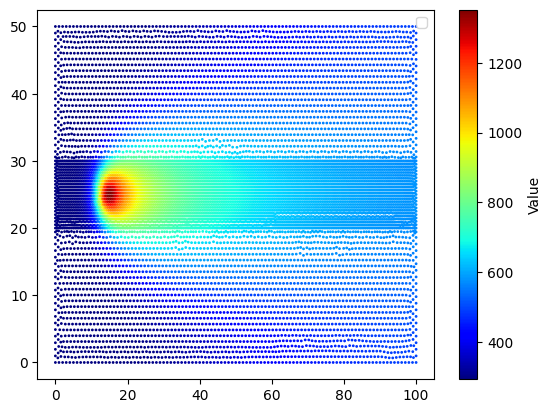

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


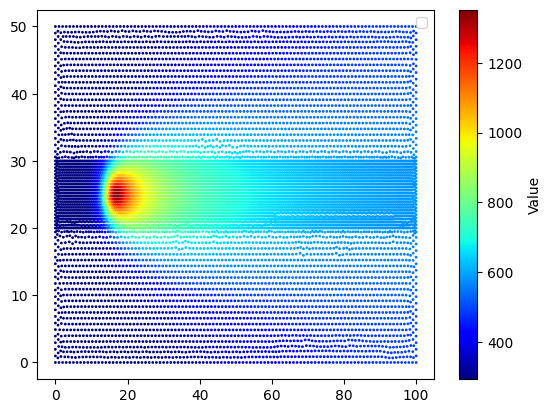

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


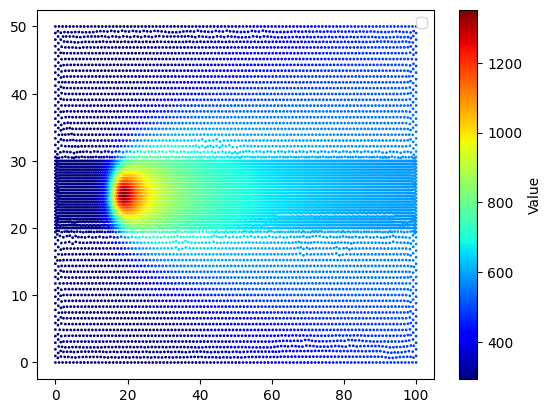

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


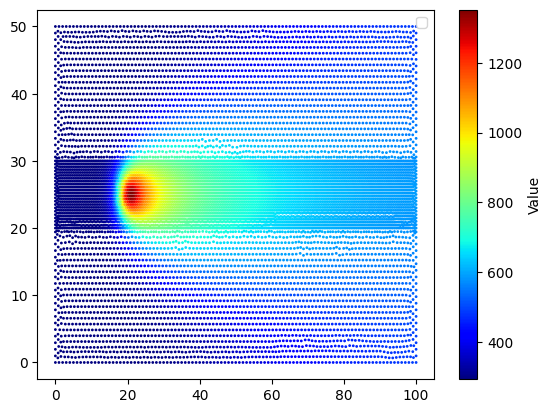

In [40]:
print(np.max(T))
plt.figure(figsize=(8,4))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
for timestep in range(T.shape[0]):
    scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=T[timestep,:], cmap='jet', s=1, edgecolor=None)
    plt.legend()
    plt.colorbar(scatter, label='Value')
    plt.show()

1352.3103784631894


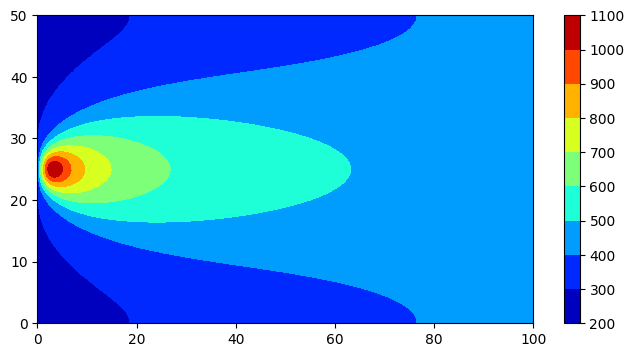

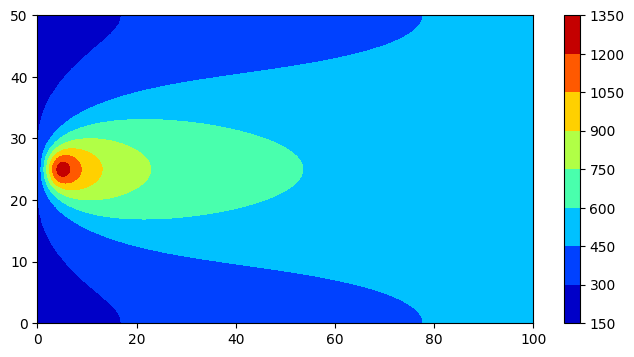

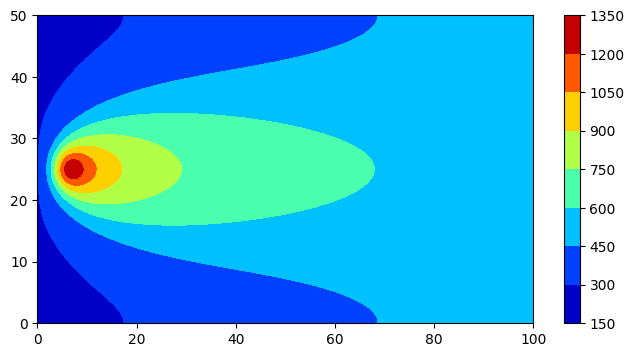

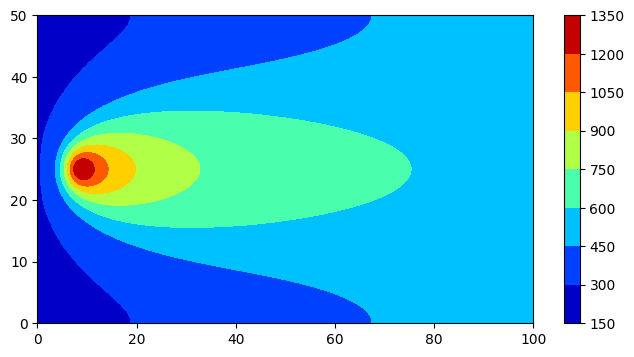

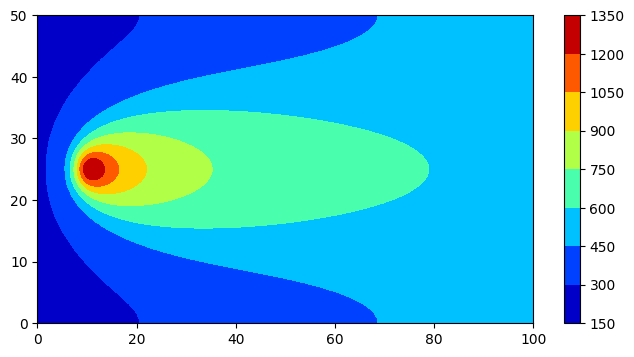

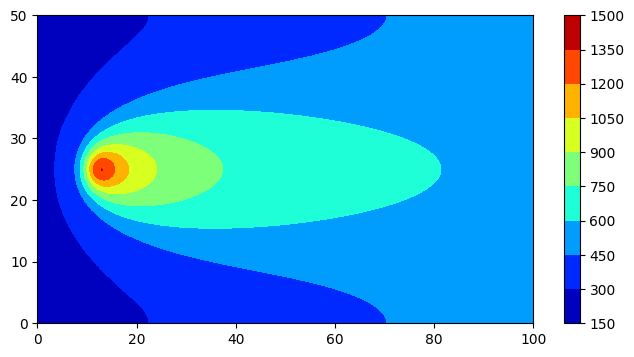

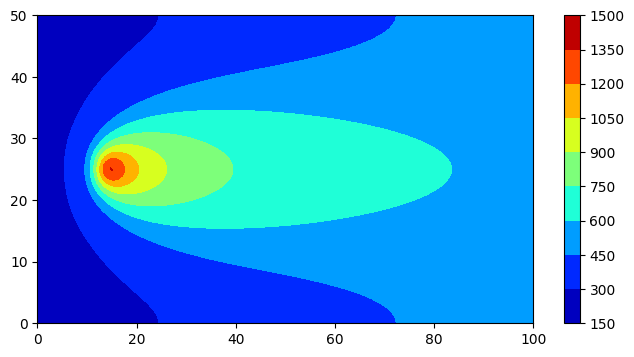

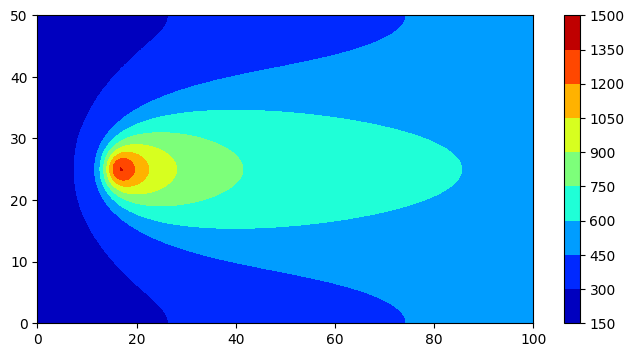

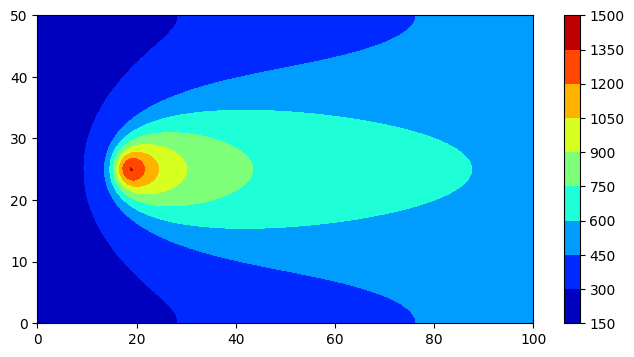

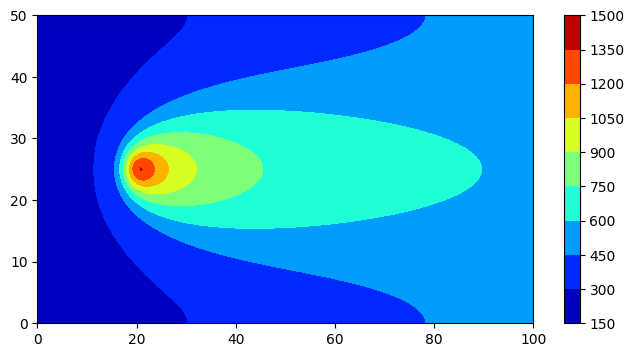

In [41]:
print(np.max(T))
for timestep in range(1,T.shape[0]):
    plt.figure(figsize=(8,4))
    plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],T[timestep,:],cmap='jet')
    plt.colorbar()
    plt.show()

In [42]:
print(np.max(T))

1352.3103784631894


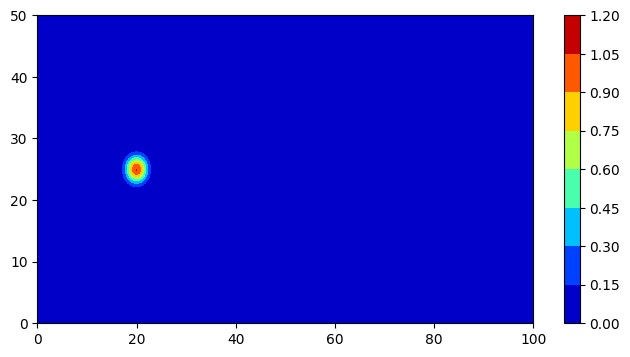

In [43]:
plt.figure(figsize=(8,4))
plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],mesh.S.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()

In [44]:
n = 0
for ele in mesh.triNodesTags:
    n += 1 if np.min(mesh.coords[ele-1,1]) >=24 and np.min(mesh.coords[ele-1,1]) <= 26 else 0
print('Value of H is '+str((100*2/n)**.5)+' in mm')

Value of H is 0.3526728079292991 in mm


In [45]:
T.shape

(11, 9806)

In [46]:
np.where(mesh.coords[:,1]>=24*mesh.coords[:,1]<=26)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
len(mesh.triNodesTags)

28910

## Don't loook at the below code it's not updated with latest implementation

In [ ]:
dn = np.array([1,2,3]).reshape(-1,1)
(dn.T@dn)[0][0]

In [ ]:
mesh = RectangularMesh(mesh_factor=2,geo_file='rectangle.geo')

In [ ]:
A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
coords = mesh.coords
dirichiletBoundary = np.where(coords[:,0] == 0)[0]
n = S.shape[0]
nodes = np.arange(n)
dirichiletBoundaryTemperature = 20
Temperature = np.ones((n,1))*dirichiletBoundaryTemperature
interiorNodes = np.delete(nodes,dirichiletBoundary)

In [ ]:
((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
Temperature[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
np.sum(((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=Temperature, cmap='jet', s=7, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

In [ ]:
np.max(Temperature)

In [ ]:
nodesForAnalysis = np.where(abs(coords[:,1]-20) <= .5)[0]
plt.title('Velcity v/s X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Velocity')
plt.scatter(coords[nodesForAnalysis, 0], Temperature[nodesForAnalysis],s=3)
plt.legend()
plt.show()